In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import glob
import shutil
import os
import gc
import pathlib
print(os.listdir("../input/"))
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Any results you write to the current directory are saved as output.

['resnet34', 'dogs-vs-cats-redux-kernels-edition']


In [2]:
from fastai.imports import *
from fastai.transforms import *
from fastai.conv_learner import *
from fastai.model import *
from fastai.dataset import *
from fastai.sgdr import *
from fastai.plots import *

In [3]:
torch.cuda.is_available()

True

In [4]:
torch.backends.cudnn.enabled

True

In [5]:
dog_indexes = []
cat_indexes = []
count = 0

In [6]:
for name in os.listdir('../input/dogs-vs-cats-redux-kernels-edition/train/'):
    if 'cat' in name:
        cat_indexes.append(name.split('.')[1])
    if 'dog' in name:
        dog_indexes.append(name.split('.')[1])

In [7]:
print ('Dog!\n',len(dog_indexes), '\nCat!\n', len(cat_indexes))

Dog!
 12500 
Cat!
 12500


In [8]:
cat_val_list = random.sample(cat_indexes, 750)
dog_val_list = random.sample(dog_indexes, 750)

In [9]:
os.makedirs('../working/dogcats/valid/cats/')
os.makedirs('../working/dogcats/valid/dogs/')
os.makedirs('../working/dogcats/train/cats/')
os.makedirs('../working/dogcats/train/dogs/')
os.makedirs('../working/dogcats/test/')

In [10]:
train_dir = "../input/dogs-vs-cats-redux-kernels-edition/train/"
test_dir = "../input/dogs-vs-cats-redux-kernels-edition/test/"
cat_train_dir = "../working/dogcats/train/cats/"
cat_valid_dir = "../working/dogcats/valid/cats/"
dog_train_dir = "../working/dogcats/train/dogs/"
dog_valid_dir = "../working/dogcats/valid/dogs/"
dogcats_test = "../working/dogcats/test/"

In [11]:
PATH = "../working/dogcats/"
sz=224

In [12]:
for jpgfile in iglob(os.path.join(train_dir, "cat*.jpg")):
    if count >= 6250:
        break
    count += 1
    if jpgfile.split('.')[3] in cat_val_list:
        shutil.copy(jpgfile, cat_valid_dir)
    else:
        shutil.copy(jpgfile, cat_train_dir)

count = 0

for jpgfile in iglob(os.path.join(train_dir, "dog*.jpg")):
    if count >= 6250:
        break
    count += 1
    if jpgfile.split('.')[3] in dog_val_list:
        shutil.copy(jpgfile, dog_valid_dir)
    else:
        shutil.copy(jpgfile, dog_train_dir)
        

In [13]:
for jpgfile in iglob(os.path.join(test_dir, "*.jpg")):
    shutil.copy(jpgfile, dogcats_test)

In [14]:
cache_dir = os.path.expanduser(os.path.join('~', '.torch'))
if not os.path.exists(cache_dir):
    os.makedirs(cache_dir)
models_dir = os.path.join(cache_dir, 'models')
if not os.path.exists(models_dir):
    os.makedirs(models_dir)

In [15]:
!cp ../input/resnet34/resnet34.pth /tmp/.torch/models/resnet34-333f7ec4.pth

md.path = pathlib.Path('.')

In [16]:
gc.collect()

186

**LOOK AT DOG PICTURES**

In [17]:
def rand_by_mask(mask): return np.random.choice(np.where(mask)[0], 4, replace=False)
def rand_by_correct(is_correct): return rand_by_mask((preds == data.val_y)==is_correct)

In [18]:
def plot_val_with_title(idxs, title):
    imgs = np.stack([data.val_ds[x][0] for x in idxs])
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(data.val_ds.denorm(imgs), rows=1, titles=title_probs)

In [19]:
def plots(ims, figsize=(12,6), rows=1, titles=None):
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None: sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i])

In [20]:
def load_img_id(ds, idx): return np.array(PIL.Image.open(PATH+ds.fnames[idx]))

def plot_val_with_title(idxs, title):
    imgs = [load_img_id(data.val_ds,x) for x in idxs]
    title_probs = [probs[x] for x in idxs]
    print(title)
    return plots(imgs, rows=1, titles=title_probs, figsize=(16,8))

In [21]:
gc.collect()

205

In [22]:
def most_by_mask(mask, mult):
    idxs = np.where(mask)[0]
    #return idxs[np.argsort(mult * probs[idxs])[:4]]
    return idxs[np.argsort(mult * probs[idxs])[:6]]

def most_by_correct(y, is_correct): 
    mult = -1 if (y==1)==is_correct else 1
    return most_by_mask(((preds == data.val_y)==is_correct) & (data.val_y == y), mult)

!rm -rf ../working/dogcats/tmp/

In [23]:
tfms = tfms_from_model(resnet34, sz, aug_tfms=transforms_side_on, max_zoom=1.1)

In [24]:
def get_augs():
    data = ImageClassifierData.from_paths(PATH, bs=2, tfms=tfms, num_workers=1)
    x,_ = next(iter(data.aug_dl))
    return data.trn_ds.denorm(x)[1]

In [25]:
arch=resnet34

In [26]:
data = ImageClassifierData.from_paths(PATH, tfms=tfms, test_name='test')
learn = ConvLearner.pretrained(arch, data, precompute=True)

100%|██████████| 196/196 [01:40<00:00,  1.96it/s]


In [27]:
learn.fit(1e-2, 1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.054266   0.033454   0.990885  



[0.033453967, 0.9908854166666666]

In [28]:
learn.precompute=False

In [29]:
learn.fit(1e-2, 3, cycle_len=1)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.053054   0.028222   0.992188  
    1      0.050329   0.029588   0.99349                      
    2      0.048319   0.0306     0.99349                      



[0.030600375, 0.9934895833333334]

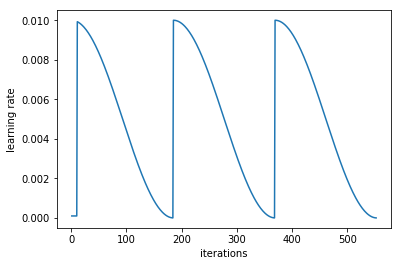

In [30]:
learn.sched.plot_lr()

In [31]:
gc.collect()

2411

In [32]:
learn.unfreeze()

In [33]:
lr=np.array([1e-4,1e-3,1e-2])

In [34]:
learn.fit(lr, 3, cycle_len=1, cycle_mult=2)

A Jupyter Widget

epoch      trn_loss   val_loss   accuracy                     
    0      0.05514    0.025891   0.99349   
    1      0.050249   0.020692   0.994792                     
    2      0.035028   0.018683   0.994792                     
    3      0.039758   0.019032   0.996094                     
    4      0.030862   0.018923   0.996094                     
    5      0.022414   0.018058   0.996094                     
    6      0.020505   0.018364   0.996094                     



[0.018364144, 0.99609375]

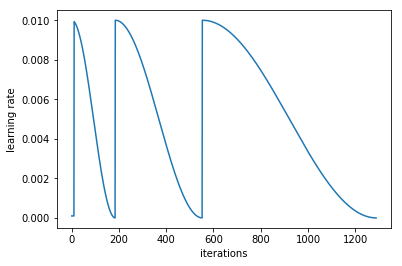

In [35]:
learn.sched.plot_lr()

In [36]:
log_preds,y = learn.TTA()
probs = np.mean(np.exp(log_preds),0)

In [37]:
accuracy_np(probs, y)

0.9946452476572959

In [38]:
preds = np.argmax(probs, axis=1)
probs = probs[:,1]

In [39]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y, preds)

[[376   3]
 [  1 367]]


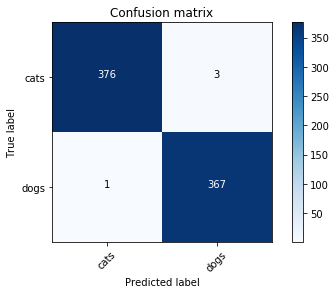

In [40]:
plot_confusion_matrix(cm, data.classes)

plot_val_with_title(most_by_correct(0, False), "Most incorrect cats")

plot_val_with_title(most_by_correct(1, False), "Most incorrect dogs")

In [41]:
temp = learn.predict(is_test=True)

In [42]:
temp.shape

(12500, 2)

In [43]:
pred_test = np.argmax(temp, axis=1)

In [44]:
pred_test[:20]

array([0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1])

In [45]:
probs = np.exp(temp[:,1])

In [46]:
probs[:10]

array([0.00001, 0.00011, 0.00005, 0.99999, 0.99974, 0.00009, 0.00039, 0.     , 1.     , 0.99988],
      dtype=float32)

In [47]:
os.listdir(f'{PATH}test')[:4]

['2477.jpg', '6392.jpg', '8451.jpg', '1610.jpg']

2477.jpg
6392.jpg
8451.jpg
1610.jpg


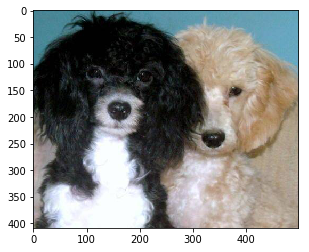

In [48]:
for image in os.listdir(f'{PATH}test')[:4]:
    img = plt.imread(f'../working/dogcats/test/{image}')
    plt.imshow(img)
    print (image)

img = plt.imread(f'./dogcats/train/dogs/{files[1]}')
plt.imshow(img)

In [49]:
submission = pd.DataFrame({'id':os.listdir(f'{PATH}test'), 'label':probs})

In [72]:
! ls ../working/

In [59]:
submission['id'] = submission['id'].map(lambda x: x.split('.')[0])

In [68]:
submission['id'] = submission['id'].astype(int)

In [71]:
submission = submission.sort_values('id')

In [73]:
submission.to_csv('../working/output.csv', index=False)